<a href="https://colab.research.google.com/github/yu-esther/AASD4011_DeepLearningMath/blob/main/DL_MATH_PROJECT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Libraries**

In [7]:
import time
import cv2
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import imutils
import matplotlib.image as mpimg
from collections import OrderedDict
from skimage import io, transform
from math import *
import xml.etree.ElementTree as ET 

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

# **Download DLIB Dataset**

In [8]:
%%capture
if not os.path.exists('/content/ibug_300W_large_face_landmark_dataset'):
    !wget http://dlib.net/files/data/ibug_300W_large_face_landmark_dataset.tar.gz
    !tar -xvzf 'ibug_300W_large_face_landmark_dataset.tar.gz'    
    !rm -r 'ibug_300W_large_face_landmark_dataset.tar.gz'

# **Examine the plot**

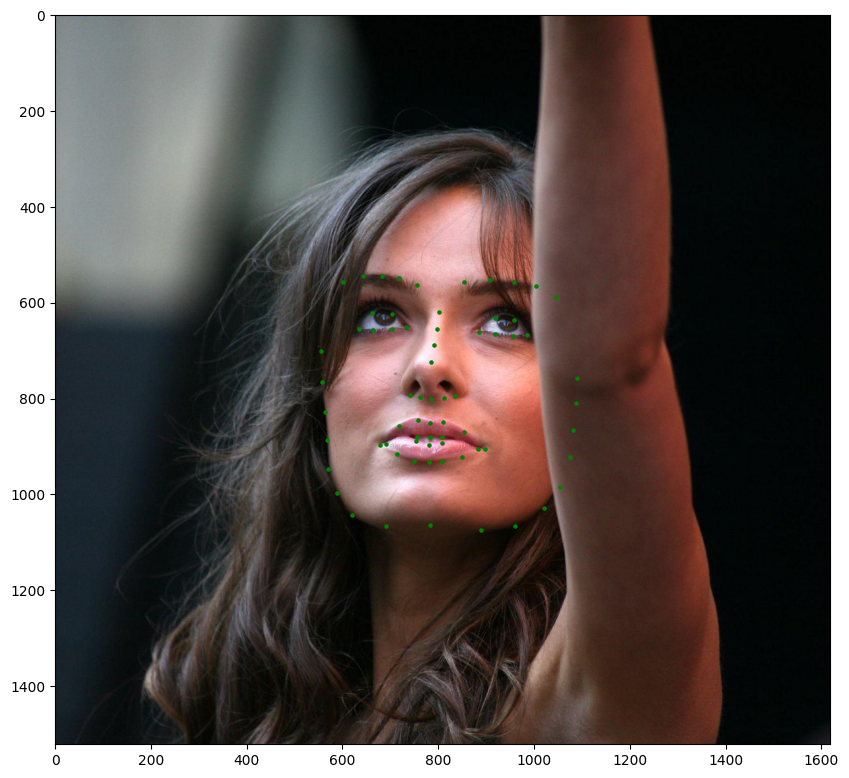

In [9]:
file = open('ibug_300W_large_face_landmark_dataset/helen/trainset/100032540_1.pts')
points = file.readlines()[3:-1]

landmarks = []

for point in points:
    x,y = point.split(' ')
    landmarks.append([floor(float(x)), floor(float(y[:-1]))])

landmarks = np.array(landmarks)

plt.figure(figsize=(10,10))
plt.imshow(mpimg.imread('ibug_300W_large_face_landmark_dataset/helen/trainset/100032540_1.jpg'))
plt.scatter(landmarks[:,0], landmarks[:,1], s = 5, c = 'g')
plt.show()

# **Image Transformation and Preprocessing Class (Transforms)**

In [15]:
import torch
import numpy as np
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from PIL import Image
from math import radians, cos, sin
import imutils
import random

class Transforms():
    def __init__(self):
        pass
    
    def rotate(self, image, landmarks, angle):
        # Generate a random angle within the specified range
        angle = random.uniform(-angle, +angle)

        # Create a 2x2 transformation matrix for rotation
        transformation_matrix = torch.tensor([
            [+cos(radians(angle)), -sin(radians(angle))], 
            [+sin(radians(angle)), +cos(radians(angle))]
        ])

        # Rotate the image using the generated angle
        image = imutils.rotate(np.array(image), angle)
        # Normalize the landmarks by subtracting 0.5
        landmarks = landmarks - 0.5
        # Apply the rotation transformation to the landmarks
        new_landmarks = np.matmul(landmarks, transformation_matrix)
        # Normalize the landmarks by adding 0.5
        new_landmarks = new_landmarks + 0.5
        # Convert the image back to PIL format and return the rotated image and landmarks
        return Image.fromarray(image), new_landmarks

    def resize(self, image, landmarks, img_size):
        # Resize the image to the specified size using bilinear interpolation
        image = TF.resize(image, img_size)
        # Return the resized image and the landmarks as they are
        return image, landmarks

    def color_jitter(self, image, landmarks):
        # Apply color jitter transformations to the image
        color_jitter = transforms.ColorJitter(
            brightness=0.3,
            contrast=0.3,
            saturation=0.3,
            hue=0.1
        )
        image = color_jitter(image)
        # Return the color-jittered image and the landmarks as they are
        return image, landmarks

    def crop_face(self, image, landmarks, crops):
        # Extract the crop coordinates
        left = int(crops['left'])
        top = int(crops['top'])
        width = int(crops['width'])
        height = int(crops['height'])

        # Crop the image using the specified coordinates
        image = TF.crop(image, top, left, height, width)
        # Get the shape of the cropped image
        img_shape = np.array(image).shape
        # Adjust the landmarks by subtracting the crop coordinates
        landmarks = torch.tensor(landmarks) - torch.tensor([[left, top]])
        # Normalize the landmarks by dividing them by the image dimensions
        landmarks = landmarks / torch.tensor([img_shape[1], img_shape[0]])
        # Return the cropped image and adjusted landmarks
        return image, landmarks

    def __call__(self, image, landmarks, crops):
        # Convert the input image array to a PIL image
        image = Image.fromarray(image)
        # Apply the crop face transformation
        image, landmarks = self.crop_face(image, landmarks, crops)
        # Resize the image and landmarks to a fixed size
        image, landmarks = self.resize(image, landmarks, (224, 224))
        # Apply color jitter transformations
        image, landmarks = self.color_jitter(image, landmarks)
        # Rotate the image and landmarks
        image, landmarks = self.rotate(image, landmarks, angle=10)
        # Convert the PIL image to a tensor
        image = TF.to_tensor(image)
        # Normalize the image tensor
        image = TF.normalize(image, [0.5], [0.5])
        # Return the normalized image tensor and landmarks
        return image, landmarks


# **Custom Dataset Class for Face Landmarks**

In [16]:
class FaceLandmarksDataset(Dataset):
    def __init__(self, transform=None):
        # Load the XML file containing image filenames and landmarks
        tree = ET.parse('ibug_300W_large_face_landmark_dataset/labels_ibug_300W_train.xml')
        root = tree.getroot()

        self.image_filenames = []  # List to store image filenames
        self.landmarks = []  # List to store landmarks
        self.crops = []  # List to store crop coordinates
        self.transform = transform  # Transformations to be applied
        self.root_dir = 'ibug_300W_large_face_landmark_dataset'  # Root directory of the dataset

        # Iterate over the XML file to extract image filenames, landmarks, and crop coordinates
        for filename in root[2]:
            self.image_filenames.append(os.path.join(self.root_dir, filename.attrib['file']))
            self.crops.append(filename[0].attrib)
            landmark = []
            for num in range(68):
                x_coordinate = int(filename[0][num].attrib['x'])
                y_coordinate = int(filename[0][num].attrib['y'])
                landmark.append([x_coordinate, y_coordinate])
            self.landmarks.append(landmark)

        self.landmarks = np.array(self.landmarks).astype('float32')

        # Ensure that the number of image filenames matches the number of landmarks
        assert len(self.image_filenames) == len(self.landmarks)

    def __len__(self):
        # Return the total number of images in the dataset
        return len(self.image_filenames)

    def __getitem__(self, index):
        # Load the image and landmarks for the given index
        image = cv2.imread(self.image_filenames[index], 0)
        landmarks = self.landmarks[index]
        if self.transform:
            # Apply the specified transformations to the image and landmarks
            image, landmarks = self.transform(image, landmarks, self.crops[index])

        landmarks = landmarks - 0.5

        # Return the preprocessed image and landmarks for the given index
        return image, landmarks

# Create an instance of the FaceLandmarksDataset with the Transforms object
dataset = FaceLandmarksDataset(Transforms())


# **Visualize and Train Transformers**
 visualize the dataset by performing the transformation that the above classes will provide to the dataset

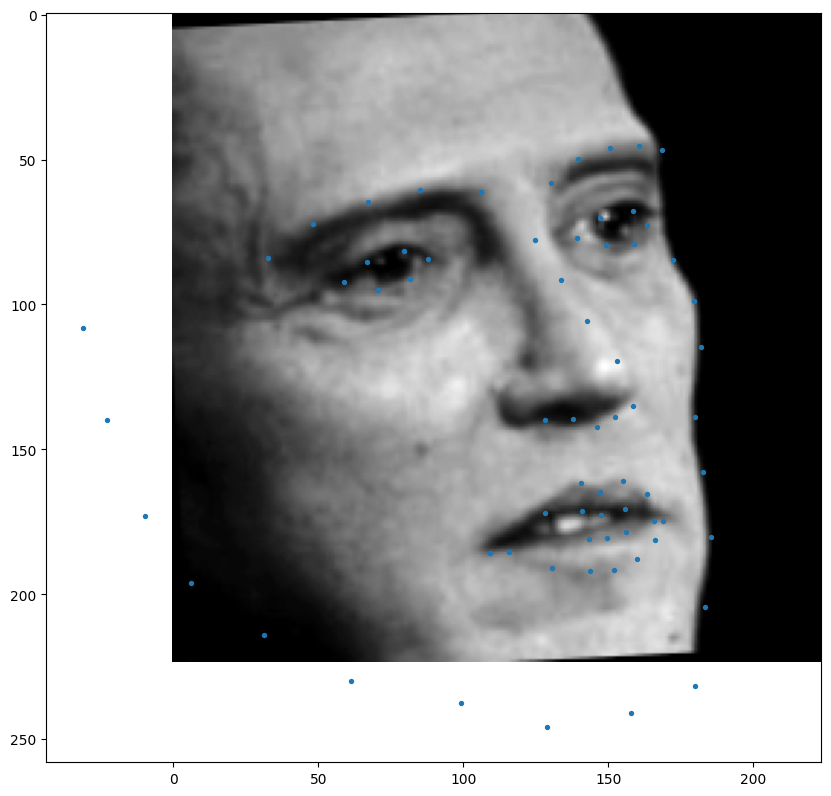

In [17]:
image, landmarks = dataset[0]
landmarks = (landmarks + 0.5) * 224
plt.figure(figsize=(10, 10))
plt.imshow(image.numpy().squeeze(), cmap='gray');
plt.scatter(landmarks[:,0], landmarks[:,1], s=8);

# **Split the Dataset for Training and Prediction of Face Landmarks**

In [18]:
# split the dataset into validation and test sets
len_valid_set = int(0.1*len(dataset))
len_train_set = len(dataset) - len_valid_set

print("The length of Train set is {}".format(len_train_set))
print("The length of Valid set is {}".format(len_valid_set))

train_dataset , valid_dataset,  = torch.utils.data.random_split(dataset , [len_train_set, len_valid_set])

# shuffle and batch the datasets
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=8, shuffle=True, num_workers=4)

The length of Train set is 6000
The length of Valid set is 666


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# **Testing the shape of input data:**

In [19]:
images, landmarks = next(iter(train_loader))

print(images.shape)
print(landmarks.shape)

torch.Size([64, 1, 224, 224])
torch.Size([64, 68, 2])
